In [ ]:
!pip install PySastrawi

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
#import semua library yang kalian butuhkan disini

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import json
import tweepy
import re
import string
import nltk

nltk.download('stopwords')
nltk.download('punkt')

from requests_oauthlib import OAuth1
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from nltk.probability import FreqDist

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# **DATA COLLECTION**

In [ ]:
#sel ini digunakan untuk membaca tokens kalian. simpan berkas token.json pada folder yang sama dengan file tugas ini

with open("token.json") as f:
  tokens = json.load(f)

bearer_token = tokens['bearer_token']
api_key = tokens['api_key']
api_key_secret = tokens['api_key_secret']
access_token = tokens['access_token']
access_token_secret = tokens['access_token_secret']

tokens.keys()

dict_keys(['api_key', 'api_key_secret', 'access_token', 'access_token_secret', 'bearer_token'])

In [ ]:
#buat variabel authentikasi dan api
auth = tweepy.OAuthHandler(api_key, api_key_secret)
auth.set_access_token(access_token, access_token_secret)
api = tweepy.API(auth, wait_on_rate_limit=True)

In [ ]:
#Buatlah sebuah fungsi dengan nama user_timeline_scraper()
#fungsi tersebut memiliki input username dari user
#Fungsi ini berguna untuk mengambil 10 tweet yang berada di timeline user.
#gunakan metode Cursor untuk tugas ini
#gunakan tweet_mode --> extended

twList = []
def user_timeline_scraper(username):
  max_tweets = 10
  tweets = tweepy.Cursor(api.user_timeline,id=username).items(max_tweets)
  for tweet in tweets:
    twList.append(tweet.text)
    print(f'{tweet.text} \n')

In [ ]:
username = "MataNajwa"
user_timeline_scraper(username)

https://t.co/k4E5Hxv67U 

Loh loh kok banyak TNI-AL? Loh kok tiba-tiba di kapal? Mata Najwa lagi main-main ke mana nih, ada yang bisa tebak?… https://t.co/sYryFvxwUM 

@patih_ahmad Iya, harusnya 2003 

PDIP mengusulkan sistem pemilu tertutup di 2024 nanti. Kayak apa sih sistem ini, apa bedanya sama sistem sebelumnya… https://t.co/DjNy0wCzXT 

Presiden Jokowi mengakui 12 pelanggaran HAM berat di Indonesia yang terjadi pada masa lalu. Pengakuan tersebut disa… https://t.co/b3aA5sJSc6 

Gimana pendapat kamu soal teknologi masa depan ini? Yuk ber-Musyawarah!

Episode lengkap dari cuplikan di atas bisa… https://t.co/O2NIPy7d0O 

Kita di Musyawarah juga pernah nyobain. Ada rasa takjub, tapi di sisi lain khawatir juga nih. Di masa depan banyak… https://t.co/WaHT4h9ccm 

Ada yang udah pernah nyobain Chat GPT atau teknologi Open AI belum nih? 

Penangkapan ini disertai kericuhan karena beberapa massa yang pendukung Lukas Enembe menyerang Mako Brimob Kotaraja, Kota Jayapura. 

Ketua KPK, Firli Ba

# **DATA PREPARATION**

In [ ]:
df = pd.DataFrame(twList, columns=['tweet'])
df

,tweet
0,https://t.co/k4E5Hxv67U
1,Loh loh kok banyak TNI-AL? Loh kok tiba-tiba d...
2,"@patih_ahmad Iya, harusnya 2003"
3,PDIP mengusulkan sistem pemilu tertutup di 202...
4,Presiden Jokowi mengakui 12 pelanggaran HAM be...
5,Gimana pendapat kamu soal teknologi masa depan...
6,Kita di Musyawarah juga pernah nyobain. Ada ra...
7,Ada yang udah pernah nyobain Chat GPT atau tek...
8,Penangkapan ini disertai kericuhan karena bebe...
9,"Ketua KPK, Firli Bahuri, bahkan pernah terbang..."


In [ ]:
def casefolding(text):
  # 1. lowercase
  text = text.lower()

  # 4. menghilangkan username dan tautan
  text = ' '.join(re.sub('@[^\s]+','',text).split())
  text = ' '.join(re.sub(r'http\S+', '', text).split())

  # 2. menghilangkan angka
  text = re.sub(r"\d+", "", text)

  # 3. menghilangkan tanda baca
  text = text.translate(str.maketrans("","",string.punctuation))
  
  # 5. menghilangkan whitespaces
  text = text.strip()

  return text

In [ ]:
df['clean'] = df['tweet'].apply(casefolding)
df

,tweet,clean
0,https://t.co/k4E5Hxv67U,
1,Loh loh kok banyak TNI-AL? Loh kok tiba-tiba d...,loh loh kok banyak tnial loh kok tibatiba di k...
2,"@patih_ahmad Iya, harusnya 2003",iya harusnya
3,PDIP mengusulkan sistem pemilu tertutup di 202...,pdip mengusulkan sistem pemilu tertutup di na...
4,Presiden Jokowi mengakui 12 pelanggaran HAM be...,presiden jokowi mengakui pelanggaran ham bera...
5,Gimana pendapat kamu soal teknologi masa depan...,gimana pendapat kamu soal teknologi masa depan...
6,Kita di Musyawarah juga pernah nyobain. Ada ra...,kita di musyawarah juga pernah nyobain ada ras...
7,Ada yang udah pernah nyobain Chat GPT atau tek...,ada yang udah pernah nyobain chat gpt atau tek...
8,Penangkapan ini disertai kericuhan karena bebe...,penangkapan ini disertai kericuhan karena bebe...
9,"Ketua KPK, Firli Bahuri, bahkan pernah terbang...",ketua kpk firli bahuri bahkan pernah terbang k...


In [ ]:
stop_words = stopwords.words('indonesian')
stop_words.extend(['loh', 'nih'])
stop_words = set(stop_words)

word_tokens = df['clean'].apply(word_tokenize)
df['clean'] = [' '.join(map(str, l)) for l in word_tokens.apply(lambda x: [item for item in x if item not in stop_words])]
df

,tweet,clean
0,https://t.co/k4E5Hxv67U,
1,Loh loh kok banyak TNI-AL? Loh kok tiba-tiba d...,tnial tibatiba kapal mata najwa mainmain tebak…
2,"@patih_ahmad Iya, harusnya 2003",iya
3,PDIP mengusulkan sistem pemilu tertutup di 202...,pdip mengusulkan sistem pemilu tertutup kayak ...
4,Presiden Jokowi mengakui 12 pelanggaran HAM be...,presiden jokowi mengakui pelanggaran ham berat...
5,Gimana pendapat kamu soal teknologi masa depan...,gimana pendapat teknologi yuk bermusyawarah ep...
6,Kita di Musyawarah juga pernah nyobain. Ada ra...,musyawarah nyobain takjub sisi khawatir banyak…
7,Ada yang udah pernah nyobain Chat GPT atau tek...,udah nyobain chat gpt teknologi open ai
8,Penangkapan ini disertai kericuhan karena bebe...,penangkapan disertai kericuhan massa pendukung...
9,"Ketua KPK, Firli Bahuri, bahkan pernah terbang...",ketua kpk firli bahuri terbang papua lukas ene...


In [ ]:
factory = StemmerFactory()
stemmer = factory.create_stemmer()

def stemming(text):
  text = stemmer.stem(text)
  return text

In [ ]:
df['clean'] = df['clean'].apply(stemming)
df

,tweet,clean
0,https://t.co/k4E5Hxv67U,
1,Loh loh kok banyak TNI-AL? Loh kok tiba-tiba d...,tnial tibatiba kapal mata najwa mainmain tebak
2,"@patih_ahmad Iya, harusnya 2003",iya
3,PDIP mengusulkan sistem pemilu tertutup di 202...,pdip usul sistem milu tutup kayak sih sistem b...
4,Presiden Jokowi mengakui 12 pelanggaran HAM be...,presiden jokowi aku langgar ham berat indonesi...
5,Gimana pendapat kamu soal teknologi masa depan...,gimana dapat teknologi yuk musyawarah episode ...
6,Kita di Musyawarah juga pernah nyobain. Ada ra...,musyawarah nyobain takjub sisi khawatir banyak
7,Ada yang udah pernah nyobain Chat GPT atau tek...,udah nyobain chat gpt teknologi open ai
8,Penangkapan ini disertai kericuhan karena bebe...,tangkap serta ricuh massa dukung lukas enembe ...
9,"Ketua KPK, Firli Bahuri, bahkan pernah terbang...",ketua kpk firli bahuri terbang papua lukas ene...


# **DATA PROCESSING**

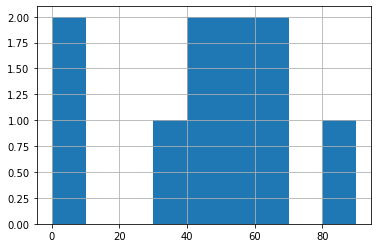

In [ ]:
# Distribusi Frekuensi Jumlah Karakter per Data

bin_range = np.arange(0, 100, 10)
df['clean'].str.len().hist(bins=bin_range)
plt.show()

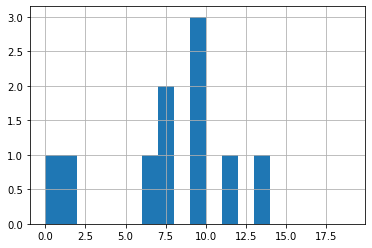

In [ ]:
# Distribusi Frekuensi Jumlah Kata per Data

bin_range = np.arange(0, 20)
df['clean'].str.split().map(lambda x: len(x)).hist(bins=bin_range)
plt.show()

/usr/local/lib/python3.8/dist-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.8/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


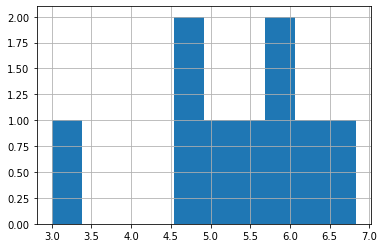

In [ ]:
# Distribusi Frekuensi Panjang Kata Rata-Rata Pada Data

df['clean'].str.split().apply(lambda x : [len(i) for i in x]).map(lambda x: np.mean(x)).hist()
plt.show()

In [ ]:
# Distribusi Frekuensi Kata

df['clean'] = df['clean'].apply(lambda x: word_tokenize(str(x)))
tweets = [word for tweet in df['clean'] for word in tweet]

fqdist = FreqDist(tweets)
print(fqdist)

<FreqDist with 64 samples and 72 outcomes>


In [ ]:
# Mengetahui kata dan jumlah dari masing-masing kata

most_common_word = fqdist.most_common(20)
print(most_common_word)

[('sistem', 3), ('aku', 2), ('teknologi', 2), ('musyawarah', 2), ('nyobain', 2), ('lukas', 2), ('enembe', 2), ('tnial', 1), ('tibatiba', 1), ('kapal', 1), ('mata', 1), ('najwa', 1), ('mainmain', 1), ('tebak', 1), ('iya', 1), ('pdip', 1), ('usul', 1), ('milu', 1), ('tutup', 1), ('kayak', 1)]


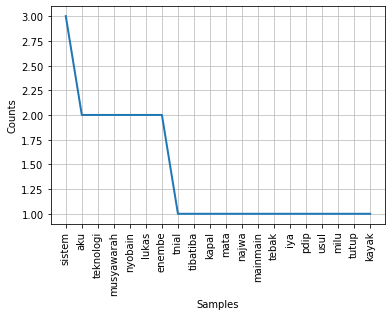

In [ ]:
# Visualisasi
fqdist.plot(20,cumulative=False)
plt.show()

In [ ]:
# Distribusi Bi-Gram

result = pd.Series(nltk.ngrams(tweets, 2)).value_counts()[:20]
print (result)

(lukas, enembe)          2
(tnial, tibatiba)        1
(ricuh, massa)           1
(tangkap, serta)         1
(ai, tangkap)            1
(open, ai)               1
(teknologi, open)        1
(gpt, teknologi)         1
(chat, gpt)              1
(nyobain, chat)          1
(udah, nyobain)          1
(banyak, udah)           1
(khawatir, banyak)       1
(sisi, khawatir)         1
(takjub, sisi)           1
(nyobain, takjub)        1
(musyawarah, nyobain)    1
(serta, ricuh)           1
(massa, dukung)          1
(tibatiba, kapal)        1
dtype: int64


# **Analysis**

Saya menganalisis 10 tweet terakhir Twitter dengan username MataNajwa.
- Berdasarkan **Distribusi Frekuensi Jumlah Karakter per Data** diketahui bahwa distribusi terbanyak berada pada 50 - 70 karakter per tweet. Dengan tweet yang memiliki panjang diatas 80 karakter, setiap nilainya tidak lebih dari 1 tweet.
- Berdasarkan **Distribusi Frekuensi Jumlah Kata per Data** diketahui bahwa distribusi terbanyak berada pada 6 - 10 kata per tweet. Tweet dengan jumlah kata di atas 12 tidak terlalu banyak.
- Berdasarkan **Distribusi Frekuensi Panjang Kata Rata-Rata Pada Data** diketahui bahwa 
- Berdasarkan **Distribusi Frekuensi Kata** diketahui bahwa distribusi terbanyak berada pada 4,5-5 karakter dan 6-6,5 per kata per tweet. Jumlah huruf pada kata yang umum ada pada bahasa indonesia. 
- Berdasarkan **Distribusi Bi-Gram** diketahui bahwa keseluruhan tweet membahas tentang lukas enembe